<a href="https://colab.research.google.com/github/TheAmirHK/Genetic_Algorithm_Parallelization/blob/main/NSGA2_Codes/NSGA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [55]:
# In[define the parameters and variables]

INTEGER_INDICES = [0, 1]
CONTINUOUS_INDICES = [2, 3]
BOUNDS = [(1, 10)] * 4

pop_size = 500
generations = 500
MUTATION_RATE = 0.15
CROSSOVER_RATE = 0.92

In [56]:
# In[define the objective functions]

def evaluate(individual):
    x1, x2, x3, x4 = individual
    obj1 = x1**2 + 2*x2**2 - 4*x3**2 + 11*x4**3  # minimize
    obj2 = -(x1 - 2*x2**3 - 10*x3**2 - 11*x4**2 + x1*x2)  # maximize
    obj3 = x1*x2 + x3**2 - 5*x4  # minimize
    return obj1, obj2, obj3

In [57]:
# In[define the constriants]

def _constriants(individual):
    """Check if constraints are satisfied."""
    x1, x2, x3, x4 = individual
    return (x1 + x2 <= 5) and (x3**2 + x4**2 - x2*x1*x3 <= 20)

In [58]:
# In[check if fitness values fit1 dominate fit2]

def dominates(fit1, fit2):
    return all(x <= y for x, y in zip(fit1, fit2)) and any(x < y for x, y in zip(fit1, fit2))

In [59]:
def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            if i in INTEGER_INDICES:
                individual[i] = random.randint(*BOUNDS[i])
            else:
                individual[i] += random.uniform(-0.5, 0.5)
                individual[i] = max(BOUNDS[i][0], min(BOUNDS[i][1], individual[i]))
    return individual

In [60]:
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:point] + parent2[point:]
        child2 = parent2[:point] + parent1[point:]

        for i in INTEGER_INDICES:
            child1[i] = int(round(child1[i]))
            child2[i] = int(round(child2[i]))

        return child1, child2
    return parent1, parent2

In [61]:
# In[non-dominated sorting action to create Pareto fronts]

def non_dominated_sort(population, fitness_values):
    fronts = [[]]
    dom_count = {}
    dom_set = {}

    for i, fit in enumerate(fitness_values):
        dom_set[i] = []
        dom_count[i] = 0
        for j, other_fit in enumerate(fitness_values):
            if dominates(fit, other_fit):
                dom_set[i].append(j)
            elif dominates(other_fit, fit):
                dom_count[i] += 1
        if dom_count[i] == 0:
            fronts[0].append(i)

    current_front = 0
    while fronts[current_front]:
        next_front = []
        for i in fronts[current_front]:
            for j in dom_set[i]:
                dom_count[j] -= 1
                if dom_count[j] == 0:
                    next_front.append(j)
        current_front += 1
        fronts.append(next_front)
    return fronts[:-1]

In [62]:
# In[crowding distance evaluation]

def crowding_distance(front, fitness_values):
    distances = np.zeros(len(front))
    for m in range(len(fitness_values[0])):
        sorted_indices = np.argsort([fitness_values[i][m] for i in front])
        distances[sorted_indices[0]] = distances[sorted_indices[-1]] = np.inf
        f_min, f_max = fitness_values[sorted_indices[0]][m], fitness_values[sorted_indices[-1]][m]
        if f_max > f_min:
            for i in range(1, len(front) - 1):
                distances[sorted_indices[i]] += (fitness_values[sorted_indices[i + 1]][m] -
                                                 fitness_values[sorted_indices[i - 1]][m]) / (f_max - f_min + 1e-9)
    return distances

In [63]:
# In[here comes the magic :)]

def NSGA2(pop_size, generations):
    population = [list((random.randint(1, 10), random.randint(1, 10), random.uniform(1, 10), random.uniform(1, 10)))
                  for _ in range(pop_size)]

    for gen in tqdm(range(generations)):
        fitness_values = [evaluate(ind) for ind in population]
        feasible_population = [ind for ind, fit in zip(population, fitness_values) if _constriants(ind)]
        feasible_fitness = [fit for ind, fit in zip(population, fitness_values) if _constriants(ind)]

        fronts = non_dominated_sort(feasible_population, feasible_fitness)
        new_population = []

        for front in fronts:
            if len(new_population) + len(front) > pop_size:
                distances = crowding_distance(front, feasible_fitness)
                sorted_front = sorted(zip(front, distances), key=lambda x: -x[1])
                new_population.extend([feasible_population[i] for i, _ in sorted_front[:pop_size - len(new_population)]])
                break
            new_population.extend([feasible_population[i] for i in front])

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = random.sample(new_population, 2)
            c1, c2 = crossover(p1, p2)
            offspring.extend([mutate(c1), mutate(c2)])

        population = offspring[:pop_size]

    final_fitness = [evaluate(ind) for ind in population]
    final_fronts = non_dominated_sort(population, final_fitness)
    pareto_front = [population[i] for i in final_fronts[0]]
    pareto_fitness = [final_fitness[i] for i in final_fronts[0]]

    return pareto_front, pareto_fitness, final_fitness

In [64]:
def plot_pareto(pareto_fitness, all_fitness):

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    all_fitness = np.array(all_fitness)
    pareto_fitness = np.array(pareto_fitness)

    ax.view_init(elev=10, azim=-150)
    ax.scatter(all_fitness[:, 0], all_fitness[:, 1],all_fitness[:, 2], color='gray', alpha=0.5, label='All Feasible Solutions')
    ax.scatter(pareto_fitness[:, 0], pareto_fitness[:, 1], pareto_fitness[:, 2], c='r', marker='o', label='Pareto Front')

    ax.set_xlabel("Min Obj 1")
    ax.set_ylabel("Max Obj 2")
    ax.set_zlabel("Min Obj 3")
    ax.set_title("Pareto Front")
    plt.legend()
    plt.show()

100%|██████████| 500/500 [02:17<00:00,  3.64it/s]


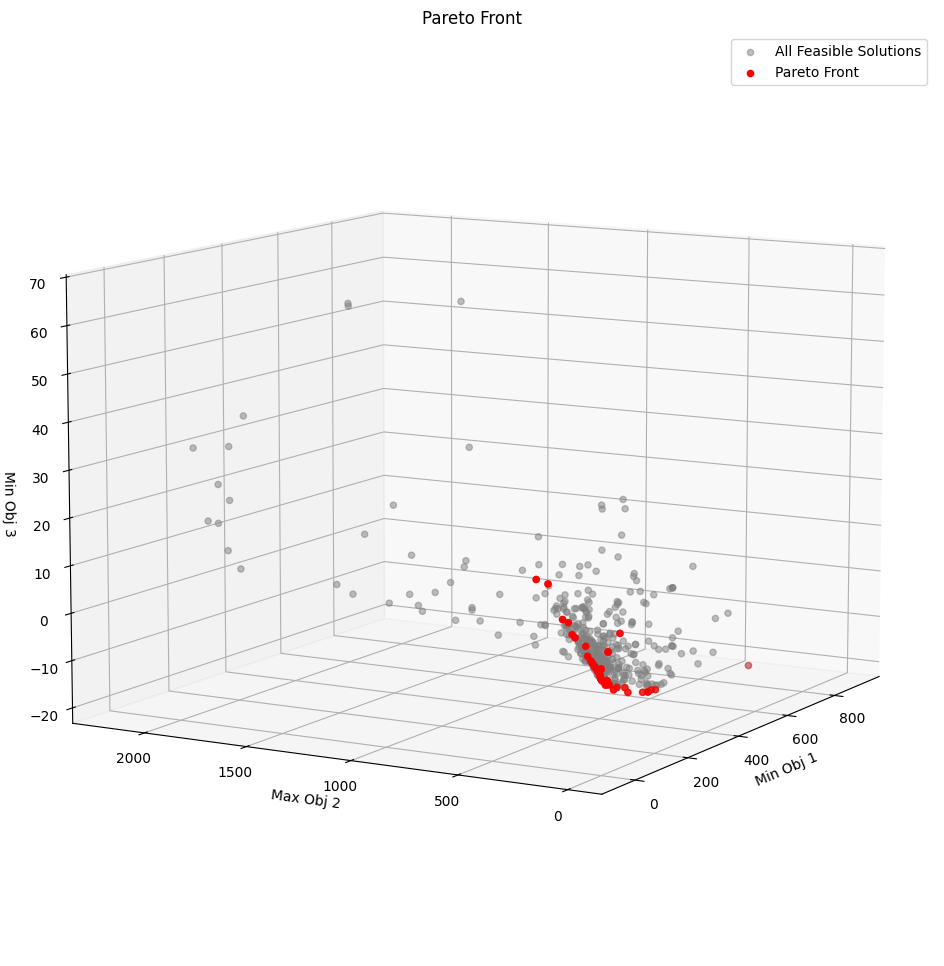

In [65]:
if __name__ == "__main__":
    pareto_front, pareto_fitness, all_fitness = NSGA2(pop_size, generations)
    plot_pareto(pareto_fitness, all_fitness)